# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [3]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [4]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [5]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [6]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [7]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [8]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [196]:
training.get_word_Xlengths('ALL')

(array([[-64,  36,  31, 180],
        [-64,  36,  31, 180],
        [-64,  36,  31, 180],
        [-64,  36,  31, 180],
        [-71,  39,  31, 180],
        [-71,  39,  31, 180],
        [-76,  43,  31, 180],
        [-76,  43,  31, 180],
        [-60,  39,  35, 181],
        [-60,  39,  34, 177],
        [-54,  26,  32, 177],
        [-47,  23,  27, 169],
        [-62,  35,  22, 181],
        [-81,  29,  19, 182],
        [-92,  27,  17, 181],
        [-97,  28,  17, 181],
        [-97,  28,  17, 181],
        [-86,  21,  17, 181],
        [-68,  22,  21, 184],
        [-49,  18,  24, 183],
        [-38,  15,  25, 181],
        [-31,   9,  25, 181],
        [-28,   8,  28, 180]]), [12, 11])

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [10]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [11]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [12]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [13]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

# Add corresponding means to df
asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])
# Add corresponding stds to df
asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y'])
# Adding Z-scores to df
asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean']) / asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean']) / asl.df['left-y-std']
asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean']) / asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean']) / asl.df['right-y-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [14]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
asl.df['polar-lr'] = np.sqrt(np.square(asl.df['grnd-lx']) + np.square(asl.df['grnd-ly']))
asl.df['polar-rr'] = np.sqrt(np.square(asl.df['grnd-rx']) + np.square(asl.df['grnd-ry']))
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [292]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
asl.df['delta-lx'] = asl.df['left-x'].diff(1).fillna(0)

asl.df['delta-ly'] = asl.df['left-y'].diff(1).fillna(0)

asl.df['delta-rx'] = asl.df['right-x'].diff(1).fillna(0)

asl.df['delta-ry'] = asl.df['right-y'].diff(1).fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [402]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
asl.df['norm_polar-lr'] = (asl.df['polar-lr'] - np.min(asl.df['polar-lr'])) \
                         / (np.max(asl.df['polar-lr']) - np.min(asl.df['polar-lr']))
asl.df['delta_nplr'] = asl.df['norm_polar-lr'].diff(1).fillna(0)
asl.df['norm_polar-rr'] = (asl.df['polar-rr'] - np.min(asl.df['polar-rr'])) \
                         / (np.max(asl.df['polar-rr']) - np.min(asl.df['polar-rr']))
asl.df['delta_nprr'] = asl.df['norm_polar-rr'].diff(1).fillna(0)
asl.df['norm_polar-ltheta'] = (asl.df['polar-ltheta'] - np.min(asl.df['polar-ltheta'])) \
                         / (np.max(asl.df['polar-ltheta']) - np.min(asl.df['polar-ltheta'])) 
asl.df['delta_npltheta'] = asl.df['norm_polar-ltheta'].diff(1).fillna(0)
asl.df['norm_polar-rtheta'] = (asl.df['polar-rtheta'] - np.min(asl.df['polar-rtheta'])) \
                         / (np.max(asl.df['polar-rtheta']) - np.min(asl.df['polar-rtheta'])) 
    
# TODO define a list named 'features_custom' for building the training set
features_custom = ['norm_polar-rr', 'norm_polar-rtheta', 'norm_polar-lr', 'norm_polar-ltheta']
# features_custom = ['delta_nprr', 'delta_nprtheta', 'delta_nplr', 'delta_npltheta']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

I chose to normalize the polar coordinates because I think that between different speakers the distances from the nose to the hands positions and the polar angle will differ so I assume that by normalizing these values I can compensate for such differences. 

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [25]:
import unittest
# import numpy as np
import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [412]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'CHICKEN'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for CHICKEN is 3
logL = -280.46497488078603


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [27]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [122]:
my_testword = 'CHICKEN'
model, logL = train_a_word(my_testword, 5, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHICKEN is 5
hidden state #0
mean =  [-12.25000019  32.          15.1250001   93.12499702]
variance =  [  4.38750289e-01   1.25000096e-03   3.60625265e-01   4.86061720e+00]

hidden state #1
mean =  [-19.          35.85686254  26.28614503  80.2845738 ]
variance =  [  1.42875864e-03   1.83780297e+00   7.63366584e+00   3.39143008e+01]

hidden state #2
mean =  [-10.          29.          20.14285456  95.00000594]
variance =  [  1.42857579e-03   1.42857579e-03   1.23875710e-01   3.71571325e+00]

hidden state #3
mean =  [-12.66762528  33.50067136  22.99999276  89.99985598]
variance =  [ 3.89610206  6.2538516   2.00136797  8.00061918]

hidden state #4
mean =  [  -8.00000626   35.99999345   14.75000069  101.74999249]
variance =  [  2.00252162   8.50251387  11.18998386   6.19002561]

logL = -136.64951611252891


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [44]:
%matplotlib inline

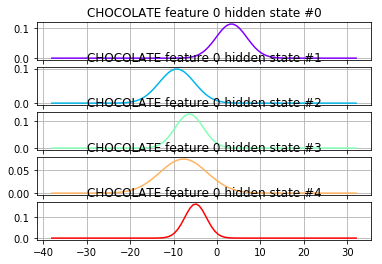

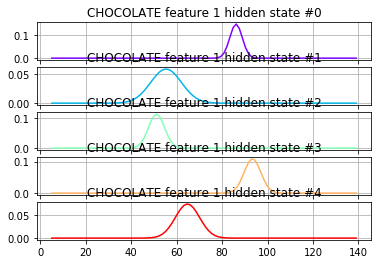

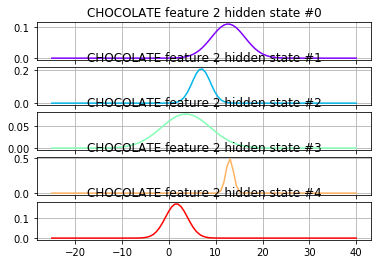

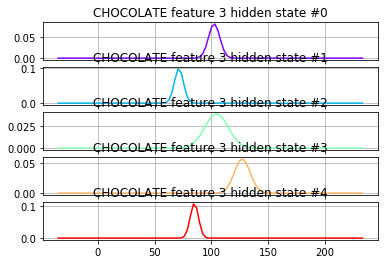

In [49]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [58]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'JOHN' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for JOHN is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [415]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'BOOK' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[ 6  7  8  9 10 11 12 13 14 15 16 17] Test fold indices:[0 1 2 3 4 5]
Train fold indices:[ 0  1  2  3  4  5 12 13 14 15 16 17] Test fold indices:[ 6  7  8  9 10 11]
Train fold indices:[ 0  1  2  3  4  5  6  7  8  9 10 11] Test fold indices:[12 13 14 15 16 17]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [60]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [61]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

In [417]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.2753131779609248 seconds
Training complete for BOOK with 12 states with time 12.1445127800107 seconds
Training complete for VEGETABLE with 11 states with time 3.082609556033276 seconds
Training complete for FUTURE with 11 states with time 11.425132570962887 seconds
Training complete for JOHN with 15 states with time 82.04450377600733 seconds


In [425]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.24623095197603106 seconds
Training complete for BOOK with 6 states with time 1.6608739040093496 seconds
Training complete for VEGETABLE with 3 states with time 0.8286892370088026 seconds
Training complete for FUTURE with 4 states with time 2.1191242130007595 seconds
Training complete for JOHN with 12 states with time 14.020066623983439 seconds


In [430]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 1.8258973290212452 seconds
Training complete for BOOK with 10 states with time 3.0516316689900123 seconds
Training complete for VEGETABLE with 4 states with time 2.4228940249886364 seconds
Training complete for FUTURE with 10 states with time 3.671107155038044 seconds
Training complete for JOHN with 15 states with time 15.731363715021871 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

**Cross-Validation (CV):**
CV splits the data into a given number of sets in order to perform the same number of train and test procedures. Each time the model is trained in a group of sets, it is immediately tested in the remaining sets. For example if the data is divided in three sets then the model is firstly trained with sets 1 and 2 and then tested with set 3. After this, training is ran again with sets 1 and 3 and tested with 2. Finally the sets 2 and 3 are used to train the model one last time while set 1 is used for testing. Each time the model is trained and tested the score is saved and at the end the average between all the trainings is computed. When looking for optimum parameters, this has the advantage of using the same data to perform multiple training iterations while trying to avoid any bias introduced by part of the data. Up to some point the more cross-validations are performed the better but this has the main disadvantage of increasing the running time when looking for the best model.   

**Bayesian Information Criterion (BIC):**
BIC is proportional to the natural logarithm of the likelihood of the data given the model multiplied by -1 plus a term accounting for the number of free parameters in the model. The later term penalizing the model for complexity, the best BIC score corresponds to the smallest one when looking for the optimum model parameters. BIC has the main advantage of favoring simple models that in this case corresponds to models with less describing nodes, thus it tries to avoid overfitting. However, the main disadvantage of BIC is that ignores how it behaves against data competing to data for which the model was conceived. 

**Discriminative Information Criterion (DIC):**
DIC is proportional to the natural logarithm of the likelihood of the data given the model minus a term penalizing for competing data similar to data for which the model was created. In other words DIC favorises models that doesn't reproduce competing data. When looking for optimal parameters, the best ones are the ones maximizing DIC. The advantage of DIC, compared to BIC and CV, is that it takes into account all the data avalaible to evaluate a model. In other words it considers the context but for the same reason its evaluation takes longer than BIC and doesn't care about complexity.

To summarize, CV has the advantage of creating several times the same model for different sets of the same data to avoid any bias or average bias introduced by part of the data, however for this reason it tends to require the longest running time during training when compared with BIC and DIC. BIC has the great advantage of generating less complex models than CV and DIC. In other words, models generated by BIC have less describing nodes than models generated by CV and DIC but at the cost of ignoring competing data, like CV. Also, given that BIC requires less evaluations than CV and DIC, it is the fastest method for selection. The strongest point of DIC is that it solves the problem of competing data but ignores complexity. It does more evaluations than BIC but less than CV so its running time is slightly higher than the one for BIC but definitely is faster than CV. 

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [431]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 71.117s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [305]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [311]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [367]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [387]:
# TODO Choose a feature set and model selector
features = features_delta # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6404494382022472
Total correct: 64 out of 178
Video  Recognized                                                    Correct
    2: JOHN *JOHN HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *HAVE *GIVE1 *TEACHER                                    JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: *MARY *MARY *JOHN *MARY *CAR *GO *FUTURE *MARY                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *JOHN IX *MARY                                     JOHN LIKE IX IX IX
   28: JOHN *MARY *MARY IX IX                                        JOHN LIKE IX IX IX
   30: JOHN *MARY *JOHN *JOHN IX                                     JOHN LIKE IX IX IX
   36: MARY *JOHN *JOHN IX *MARY *MARY                               MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *MARY MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *JOHN *FINISH HOUSE     

In [389]:
# TODO Choose a feature set and model selector
features = features_delta # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6348314606741573
Total correct: 65 out of 178
Video  Recognized                                                    Correct
    2: JOHN *GIVE1 *ARRIVE                                           JOHN WRITE HOMEWORK
    7: JOHN *BOX *GIVE1 *ARRIVE                                      JOHN CAN GO CAN
   12: JOHN *BOX *GIVE1 CAN                                          JOHN CAN GO CAN
   21: JOHN *MARY *LOVE *MARY *HOUSE *FUTURE *FUTURE *MARY           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *JOHN IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX IX                                        JOHN LIKE IX IX IX
   30: JOHN *IX IX *JOHN IX                                          JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN IX *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *JOHN MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *IX *CAR HOUSE          

In [391]:
# TODO Choose a feature set and model selector
features = features_delta # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6179775280898876
Total correct: 68 out of 178
Video  Recognized                                                    Correct
    2: JOHN *LOVE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *STUDENT *GIVE1 *STUDENT                                 JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: *MARY *MARY WONT *MARY *CAR *TOMORROW *FUTURE *MARY           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *MARY IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX *SHOULD                                   JOHN LIKE IX IX IX
   30: JOHN *IX IX *JOHN IX                                          JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN IX *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *JOHN MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *IX *FINISH HOUSE       

In [432]:
# TODO Choose a feature set and model selector
features = features_delta # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6235955056179775
Total correct: 67 out of 178
Video  Recognized                                                    Correct
    2: JOHN *GIVE1 *ARRIVE                                           JOHN WRITE HOMEWORK
    7: JOHN *BOX *GIVE1 *ARRIVE                                      JOHN CAN GO CAN
   12: JOHN *BOX *JOHN CAN                                           JOHN CAN GO CAN
   21: JOHN *MARY *LOVE *MARY *BUY *FUTURE *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *JOHN IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX *SHOULD                                   JOHN LIKE IX IX IX
   30: JOHN *IX *SHOULD *JOHN IX                                     JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN IX *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *JOHN MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

In [394]:
# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6179775280898876
Total correct: 68 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE HOMEWORK                                            JOHN WRITE HOMEWORK
    7: JOHN *WHAT *MARY *WHAT                                        JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: *IX *HOMEWORK WONT *FUTURE *CAR *CAR *GO *TOMORROW            JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *FRANK LIKE IX *WHO IX                                        JOHN LIKE IX IX IX
   28: *IX *WHO *FUTURE *FUTURE IX                                   JOHN LIKE IX IX IX
   30: *SHOULD LIKE *GO *MARY *GO                                    JOHN LIKE IX IX IX
   36: *SOMETHING-ONE VEGETABLE *GIRL *GIVE *MARY *MARY              MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *GIVE *DECIDE MARY *GO                                   JOHN IX THINK MARY LOVE
   43: *IX *GO BUY HOUSE            

In [395]:
# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5224719101123596
Total correct: 85 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW WONT *PREFER *CAR *WHAT *FUTURE *WHO                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *FUTURE IX *FUTURE *LOVE                                 JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *SUE *GIVE *GIVE *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO *GIVE *JOHN *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

In [396]:
# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE *NEW                                                JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *NEW WONT *NOT *GIVE1 *TEACHER *FUTURE *WHO              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *WHO IX                                       JOHN LIKE IX IX IX
   28: JOHN *WHO *FUTURE *WHO IX                                     JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *GIRL *GIVE *MARY *MARY                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *FUTURE1 *JOHN *MARY                              JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [433]:
# TODO Choose a feature set and model selector
features = features_polar # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.550561797752809
Total correct: 80 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *PREFER *CAR *WHAT *FUTURE *WHO               JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *FUTURE IX *FUTURE *LOVE                                 JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO *GIVE *JOHN *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE            

In [398]:
# TODO Choose a feature set and model selector
features = features_norm # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6235955056179775
Total correct: 67 out of 178
Video  Recognized                                                    Correct
    2: *MARY WRITE *ARRIVE                                           JOHN WRITE HOMEWORK
    7: JOHN *NEW *JOHN CAN                                           JOHN CAN GO CAN
   12: *SHOULD *HAVE *GO1 CAN                                        JOHN CAN GO CAN
   21: *LIKE *NEW *HAVE *IX-1P *CAR *BLAME *CHICKEN *WRITE           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *IX LIKE *LIKE *LIKE IX                                       JOHN LIKE IX IX IX
   28: *ANN LIKE *ANN *LIKE *ANN                                     JOHN LIKE IX IX IX
   30: *SHOOT LIKE *LOVE *LIKE *MARY                                 JOHN LIKE IX IX IX
   36: *LEAVE *NOT *YESTERDAY *VISIT LIKE *JOHN                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *LEAVE *FUTURE1 *VEGETABLE LOVE                          JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       

In [399]:
# TODO Choose a feature set and model selector
features = features_norm # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.601123595505618
Total correct: 71 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: *MARY *CAR GO *WHAT                                           JOHN CAN GO CAN
   12: JOHN *CAR *WHAT CAN                                           JOHN CAN GO CAN
   21: *MARY *BOX *JOHN *BLAME *CAR *CAR *FUTURE CHICKEN             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN LIKE IX *MARY IX                                         JOHN LIKE IX IX IX
   28: *ANN LIKE IX *MARY IX                                         JOHN LIKE IX IX IX
   30: *IX-1P *CHOCOLATE *MARY *LOVE *LOVE                           JOHN LIKE IX IX IX
   36: MARY *MARY *GIVE3 *WOMAN LIKE *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *JOHN *FUTURE1 MARY *MARY                               JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE        

In [400]:
# TODO Choose a feature set and model selector
features = features_norm # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6123595505617978
Total correct: 69 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: *MARY *NEW GO *WHAT                                           JOHN CAN GO CAN
   12: *MARY *HAVE *GO1 CAN                                          JOHN CAN GO CAN
   21: *MARY *BOX *HAVE *GO *CAR *CAR *CHICKEN *WRITE                JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *LIKE IX                                      JOHN LIKE IX IX IX
   28: *ANN *ANN *ANN *ANN *ANN                                      JOHN LIKE IX IX IX
   30: *IX-1P *IX *MARY IX IX                                        JOHN LIKE IX IX IX
   36: MARY *MARY *YESTERDAY *SHOOT LIKE *IX                         MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *JOHN *FUTURE1 *VEGETABLE *MARY                         JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [434]:
# TODO Choose a feature set and model selector
features = features_norm # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6235955056179775
Total correct: 67 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: *MARY *CAR GO *WHAT                                           JOHN CAN GO CAN
   12: JOHN *CAR *WHAT CAN                                           JOHN CAN GO CAN
   21: *MARY *BOX *JOHN *BLAME *CAR *CAR *FUTURE CHICKEN             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX *MARY IX                                         JOHN LIKE IX IX IX
   28: *ANN *ANN *ANN *ANN *ANN                                      JOHN LIKE IX IX IX
   30: *IX-1P *CHOCOLATE *MARY *LOVE *LOVE                           JOHN LIKE IX IX IX
   36: MARY *MARY *GIVE3 *WOMAN LIKE *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *JOHN *SEE MARY *MARY                                   JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE BUY HOUSE       

In [403]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.6573033707865169
Total correct: 61 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE HOMEWORK                                            JOHN WRITE HOMEWORK
    7: JOHN *WHAT *MARY *TOY                                         JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 *DECIDE                                       JOHN CAN GO CAN
   21: *IX-1P *VIDEOTAPE WONT *PREFER BUT *MANY *CHICKEN CHICKEN     JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *TELL *ANN *TELL *ANN                                    JOHN LIKE IX IX IX
   28: *ANN *WHO *TELL *LIKE *NOT                                    JOHN LIKE IX IX IX
   30: *SHOULD LIKE *LIKE *LIKE *LIKE                                JOHN LIKE IX IX IX
   36: *BILL VEGETABLE *GIRL *GIVE LIKE *MARY                        MARY VEGETABLE KNOW IX LIKE CORN1
   40: *SUE *TELL *CORN *JANA *LIKE                                  JOHN IX THINK MARY LOVE
   43: *FRANK *PAST BUY HOUSE       

In [404]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorCV # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.43820224719101125
Total correct: 100 out of 178
Video  Recognized                                                    Correct
    2: *SHOULD WRITE HOMEWORK                                        JOHN WRITE HOMEWORK
    7: JOHN CAN GO *TOY                                              JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *HOMEWORK WONT *PREFER BUT CAN *CHICKEN CHICKEN          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *ANN *LOVE *WHO IX                                       JOHN LIKE IX IX IX
   28: JOHN *WHO *LOVE *WHO *LOVE                                    JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *LIKE                                   JOHN LIKE IX IX IX
   36: *BILL VEGETABLE *YESTERDAY *GIVE *MARY *MARY                  MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *CORN MARY *MARY                                  JOHN IX THINK MARY LOVE
   43: JOHN *PAST BUY HOUSE       

In [406]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorBIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
    2: *GO WRITE HOMEWORK                                            JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE *MARY *TOY                                       JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *HOMEWORK WONT *PREFER BUT *PARTY *CHICKEN CHICKEN       JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *WHO *ANN *WHO *ANN                                      JOHN LIKE IX IX IX
   28: JOHN *WHO *ANN *WHO *NOT                                      JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *VISIT VEGETABLE *GIRL *GIVE *MARY *MARY                      MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *CORN *JOHN *MARY                                 JOHN IX THINK MARY LOVE
   43: JOHN *PAST BUY HOUSE         

In [435]:
# TODO Choose a feature set and model selector
features = features_custom # change as needed
model_selector = SelectorDIC # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.449438202247191
Total correct: 98 out of 178
Video  Recognized                                                    Correct
    2: *SHOULD WRITE HOMEWORK                                        JOHN WRITE HOMEWORK
    7: JOHN CAN GO *TOY                                              JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *HOMEWORK WONT *PREFER BUT CAN *CHICKEN CHICKEN          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *TELL *LOVE *WHO IX                                      JOHN LIKE IX IX IX
   28: JOHN *WHO *LOVE *WHO *LOVE                                    JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *LIKE                                   JOHN LIKE IX IX IX
   36: *BILL VEGETABLE *GIRL *GIVE *MARY *MARY                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *VISIT *CORN *JOHN *MARY                                 JOHN IX THINK MARY LOVE
   43: JOHN *PAST BUY HOUSE          

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

From the 12 possible combinations I retained the three corresponding to the features_custom I proposed given because it gave the best results for all the selectors.

The table below shows the WER for each feature and model selector:


 |Selector_CV | Selector_BIC | Selector_DIC
--- |---| --- | ---
features_custom | 43.82% | 53.93% | 44.94%
features_delta | 63.48 | 61.80 | 62.36
features_polar | 52.25 | 54.49 | 55.06
features_norm | 60.11 | 61.24 | 62.36


The WER is highly dependent on the features selected to create the models. From the table above it becomes evident that it is highly recommended to normalize the features. Even more, before normalization it seems that expressing the features in a more general and stable coordinate system is a good practice. In the results presented above the custom_features correspond to the rescaling bewteen 0 and 1 of the polar coordinates, which were considered with respect to the nose of the speaker as the center and the vertical line as the base for the polar angle.

CV and DIC gave the best results, CV being slightly better than DIC but requiring more computation. When the right features are chosen the advantage of DIC with respect to BIC becomes noticeable. This is expected from the fact that DIC takes into account competing data as opposed to BIC that only penalizes for model complexity.

From the obtained results the 'best'combination seems to be cross-validation with features_custom but knowing that cross-validation takes longer to process than DIC, the DIC with custom features combination is still a good option.

One way to improve the models could be by taking into account statistical data on the language signs. For example knowing which signs are more common or estimating which sign usually follows a given sign could really improve the models.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [408]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 17.601s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()